In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py


# Load test data

In [40]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190521_new.hdf', 'r')
strain = f1['GW190521-v3']['l1_strain'][()]


# Normalize data

In [41]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [42]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


# Reshape data into subsequences

In [43]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 10
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy
    
        
X_test_noisy = reshape_sequences(1, strain)


In [44]:
# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


# Define loss function

In [45]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

# Load trained model

In [22]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

# Load new trained model (trained with Mchirp >= 10)

In [46]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

# Obtain predictions on test data

In [47]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


# Plot test sample

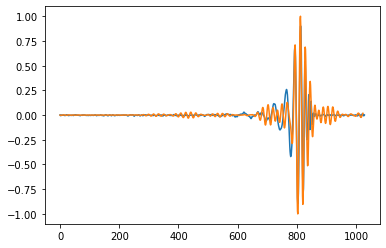

In [48]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


# Plot using new trained model

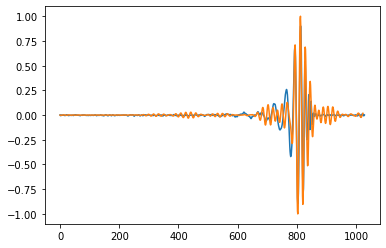

In [30]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [49]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/rec_signal_time_L1.dat",header=0,delimiter=" ")

#envelope_data = pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/rec_signal_envelope_L1.dat",header=0,delimiter=" ")


# Normalize upper and lower 90% C.I. using max and min values of cWB reconstructed waveform

In [50]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

# Find out Livingston GPS time from GraceDB

In [33]:
np.where((input_data['time,'].values > 1242442967.447) & (input_data['time,'].values < 1242442967.448))[0]


array([4554])

In [34]:
input_data['time,'].values[4554]

1242442967.4472656

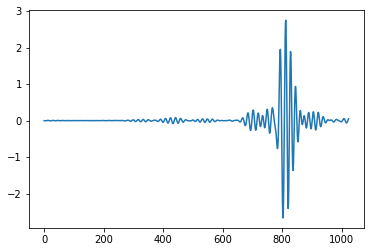

In [35]:
plt.plot(input_data['amp_cwb_rec,'].values[3735:4759])


# Find out sampling rate and then find indexes corresponding to 0.8 secs before event and 0.2 secs after event

In [36]:
4554 -(1024*0.8)

3734.8

In [37]:
4554 + (1024*0.2)

4758.8

In [80]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190521_reconstruction_CI.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


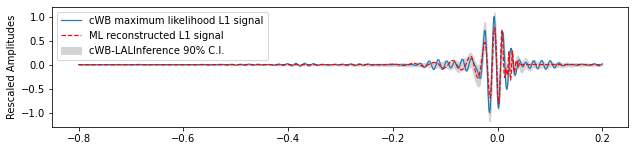

In [81]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)


In [51]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190521_reconstruction_CI_new_model.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


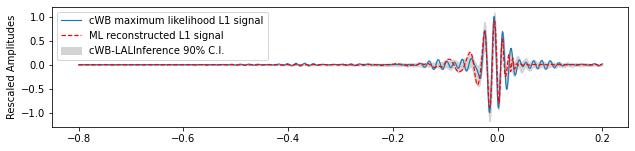

In [52]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW150914

In [53]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW150914_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [54]:
np.where((input_data['#time,'].values > 1126259462.390) & (input_data['#time,'].values < 1126259462.392))[0]


array([17183, 17184, 17185, 17186])

In [55]:
# Lower

17183 -(2048*0.8)

15544.6

In [56]:
# Upper

17183 + (2048*0.2)

17592.6

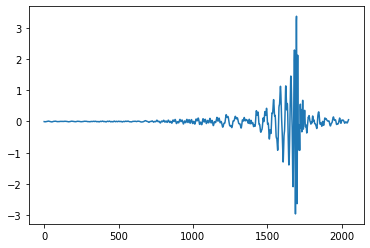

In [57]:
plt.plot(input_data['amp_cwb_point_est,'].values[15545:17593])


In [58]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW150914.hdf', 'r')
strain = f1['GW150914-v3']['l1_strain'][()]


In [59]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [60]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [61]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


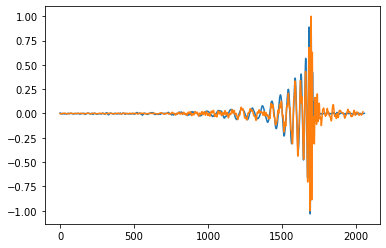

In [62]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[15545:17593][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [63]:
input_data

,"#time,","amp_cwb_point_est,","amp_pe_post_median,","amp_pe_post_lower_50_perc,","amp_pe_post_lower_90_perc,","amp_pe_post_upper_50_perc,",amp_pe_post_upper_90_perc
0,1.126259e+09,-5.204170e-18,0.000000e+00,-1.233517e-17,-2.992398e-17,1.214306e-17,3.057450e-17
1,1.126259e+09,1.929880e-17,8.673617e-19,-1.235990e-17,-3.268604e-17,1.734723e-17,4.046961e-17
2,1.126259e+09,-8.673617e-18,0.000000e+00,-1.387779e-17,-3.556183e-17,1.727781e-17,4.163336e-17
3,1.126259e+09,-3.469447e-17,0.000000e+00,-1.843144e-17,-4.423545e-17,1.387779e-17,4.163336e-17
4,1.126259e+09,-3.469447e-18,0.000000e+00,-1.387779e-17,-3.492196e-17,1.387779e-17,3.816392e-17
...,...,...,...,...,...,...,...
32763,1.126259e+09,-8.673617e-18,-1.983800e-18,-1.935316e-17,-4.597017e-17,6.601447e-18,3.166959e-17
32764,1.126259e+09,3.989864e-17,0.000000e+00,-1.105963e-17,-3.361293e-17,1.016227e-17,3.325016e-17
32765,1.126259e+09,-8.673617e-18,0.000000e+00,-1.164341e-17,-3.505285e-17,1.165596e-17,3.430683e-17
32766,1.126259e+09,1.214306e-17,0.000000e+00,-1.347833e-17,-4.047965e-17,1.204575e-17,3.895850e-17


In [64]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[15545:17593]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[15545:17593]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [65]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW150914_reconstruction_CI_new_model.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


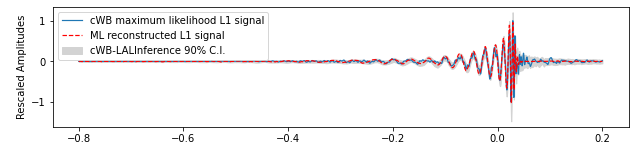

In [66]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW170608

In [67]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170608_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [68]:
np.where((input_data['#time,'].values > 1180922494.491) & (input_data['#time,'].values < 1180922494.493))[0]


array([17390, 17391, 17392, 17393])

In [69]:
input_data['#time,'].values[17390]


1180922494.4912107

In [70]:
# Lower

17390 -(2048*0.8)

15751.6

In [71]:
# Upper

17390 + (2048*0.2)

17799.6

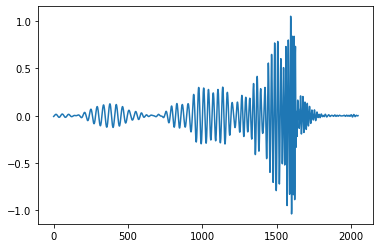

In [72]:
plt.plot(input_data['amp_cwb_point_est,'].values[15752:17800])


In [73]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170608.hdf', 'r')
strain = f1['GW170608-v3']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [74]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [75]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


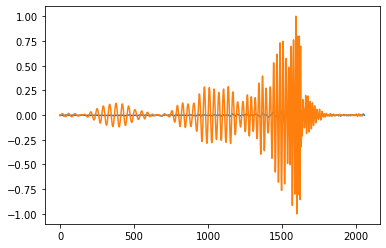

In [76]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[15752:17800][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [77]:
input_data

,"#time,","amp_cwb_point_est,","amp_pe_post_median,","amp_pe_post_lower_50_perc,","amp_pe_post_lower_90_perc,","amp_pe_post_upper_50_perc,",amp_pe_post_upper_90_perc
0,1.180922e+09,6.505213e-19,0.000000e+00,-6.071532e-18,-2.074513e-17,1.132129e-17,2.775558e-17
1,1.180922e+09,1.886512e-17,2.602085e-18,-5.204170e-18,-2.089011e-17,1.431147e-17,3.068243e-17
2,1.180922e+09,-2.602085e-18,-6.505213e-19,-1.127570e-17,-2.688821e-17,6.643171e-18,2.341877e-17
3,1.180922e+09,1.821460e-17,0.000000e+00,-8.890458e-18,-2.341877e-17,9.035118e-18,2.515349e-17
4,1.180922e+09,-8.673617e-19,0.000000e+00,-7.372575e-18,-2.255141e-17,8.673617e-18,2.385245e-17
...,...,...,...,...,...,...,...
30715,1.180923e+09,-2.427258e-17,-2.250692e-19,-1.183765e-17,-3.036817e-17,1.073053e-17,2.976357e-17
30716,1.180923e+09,1.792999e-17,-9.581673e-20,-1.119953e-17,-2.807206e-17,1.100230e-17,2.930993e-17
30717,1.180923e+09,1.138412e-17,-3.047747e-19,-1.192092e-17,-3.218163e-17,9.922848e-18,2.833033e-17
30718,1.180923e+09,-9.920450e-18,-4.645016e-19,-1.233773e-17,-3.107686e-17,1.114390e-17,3.173559e-17


In [78]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[15752:17800]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[15752:17800]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [79]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW170608_reconstruction_CI_new_model.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


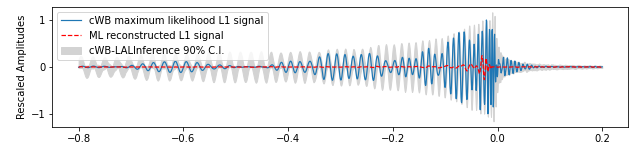

In [80]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW170729

In [81]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170729_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [82]:
np.where((input_data['#time,'].values > 1185389807.325) & (input_data['#time,'].values < 1185389807.327))[0]


array([15002, 15003, 15004, 15005])

In [83]:
input_data['#time,'].values[15002]

1185389807.3251953

In [84]:
# Lower

15002 -(2048*0.8)

13363.6

In [85]:
# Upper

15002 + (2048*0.2)

15411.6

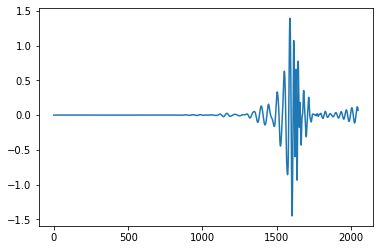

In [86]:
plt.plot(input_data['amp_cwb_point_est,'].values[13364:15412])


In [87]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170729.hdf', 'r')
strain = f1['GW170729-v1']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [88]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [89]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


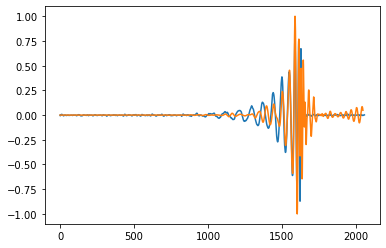

In [90]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[13364:15412][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [91]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[13364:15412]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[13364:15412]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [92]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW170729_reconstruction_CI_new_model.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


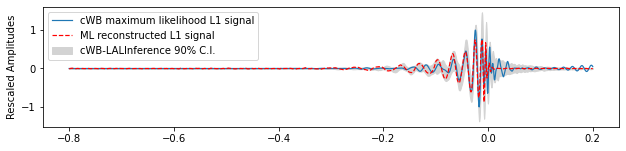

In [93]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW190412

In [94]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190412_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [95]:
np.where((input_data['time,'].values > 1239082262.200) & (input_data['time,'].values < 1239082262.202))[0]


array([8397, 8398])

In [96]:
# Lower

8397 -(1024*0.8)

7577.8

In [97]:
# Upper

8397 + (1024*0.2)

8601.8

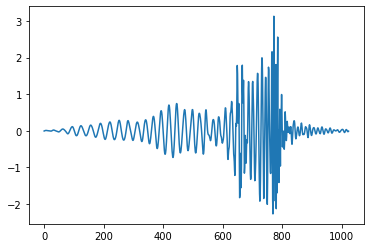

In [98]:
plt.plot(input_data['amp_cwb_rec,'].values[7578:8602])


In [99]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190412.hdf', 'r')
strain = f1['GW190412-v3']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 1024)
strain = np.array(strain)


In [100]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [101]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


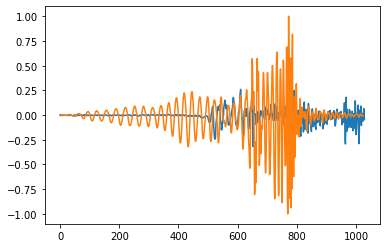

In [102]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[7578:8602][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [103]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7578:8602]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7578:8602]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [104]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190412_reconstruction_CI_new_model_trained_with_mchirp_geq_10.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


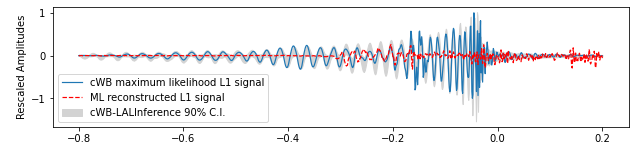

In [105]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW190814

In [106]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190814_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [107]:
np.where((input_data['time,'].values > 1249852257.011) & (input_data['time,'].values < 1249852257.013))[0]


array([10252, 10253])

In [108]:
# Lower

10252 -(1024*0.8)

9432.8

In [109]:
# Upper

10252 +(1024*0.2)

10456.8

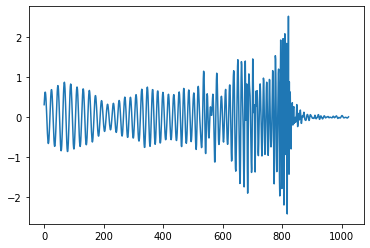

In [110]:
plt.plot(input_data['amp_cwb_rec,'].values[9433:10457])


In [111]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190814.hdf', 'r')
strain = f1['GW190814']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 1024)
strain = np.array(strain)


In [112]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [113]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


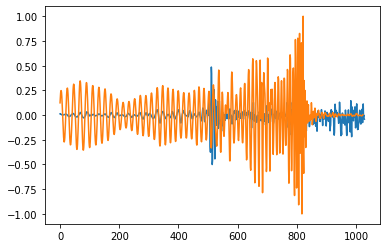

In [114]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[9433:10457][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [115]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[9433:10457]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[9433:10457]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [116]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190814_reconstruction_CI_new_model_trained_with_mchirp_geq_10.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


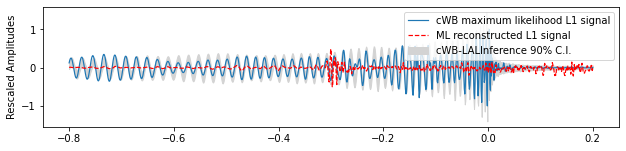

In [117]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)


# New model with dilated convolutions, 25 timesteps and MAE loss

# GW190521

In [2]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190521_new.hdf', 'r')
strain = f1['GW190521-v3']['l1_strain'][()]


In [3]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [4]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [5]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 25
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy
    
        
X_test_noisy = reshape_sequences(1, strain)


In [6]:
# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [8]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            l2 = K.mean(tf.math.abs(y_true - y_pred),axis=-1)
            result = self.tnmt_base(y_true, y_pred, scale)
        
            return  l1 + 0.1*l2 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

In [9]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps_mchirp_all_1.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    512       
 ormalization)                                                   
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 64)     2

In [10]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


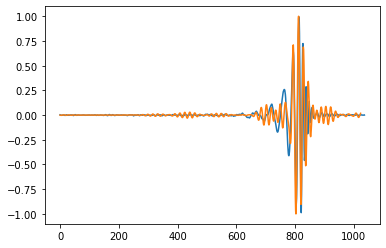

In [11]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/rec_signal_time_L1.dat",header=0,delimiter=" ")

#envelope_data = pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/rec_signal_envelope_L1.dat",header=0,delimiter=" ")

plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [12]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [15]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190521_reconstruction_CI_dilated_CNN_25_timesteps_1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


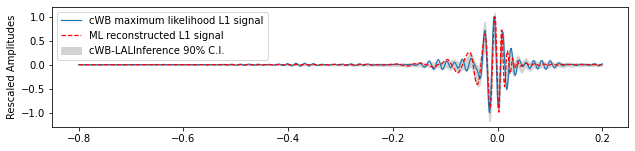

In [16]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW150914

In [17]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW150914_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [18]:
np.where((input_data['#time,'].values > 1126259462.390) & (input_data['#time,'].values < 1126259462.392))[0]


array([17183, 17184, 17185, 17186])

In [19]:
# Lower

17183 -(2048*0.8)

15544.6

In [20]:
# Upper

17183 + (2048*0.2)

17592.6

In [21]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW150914.hdf', 'r')
strain = f1['GW150914-v3']['l1_strain'][()]


In [22]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [23]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [24]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


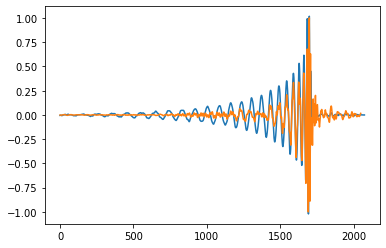

In [25]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[15545:17593][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [26]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[15545:17593]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[15545:17593]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [28]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW150914_reconstruction_CI_dilated_CNN_25_timesteps_1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


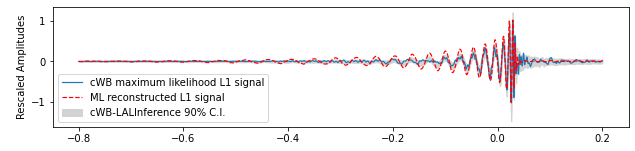

In [29]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW170608

In [30]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170608_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [31]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170608.hdf', 'r')
strain = f1['GW170608-v3']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [32]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [33]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


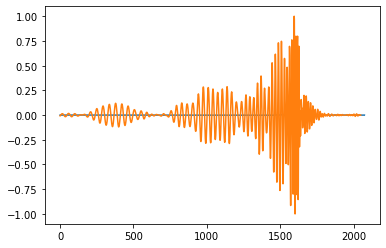

In [34]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[15752:17800][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [35]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[15752:17800]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[15752:17800]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [36]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW170608_reconstruction_CI_dilated_CNN_25_timesteps_1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


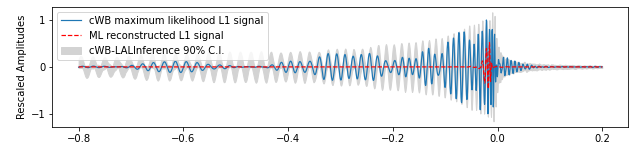

In [37]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW170729

In [38]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170729_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [39]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170729.hdf', 'r')
strain = f1['GW170729-v1']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)

X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [40]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


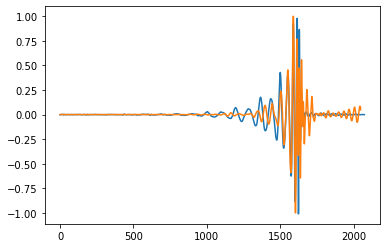

In [41]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[13364:15412][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [42]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[13364:15412]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[13364:15412]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [43]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW170729_reconstruction_CI_dilated_CNN_25_timesteps_1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


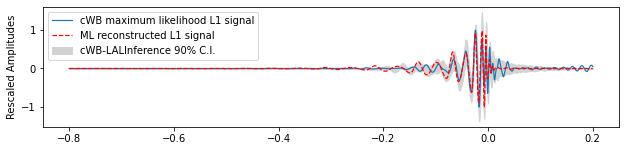

In [44]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW190412

In [45]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190412_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [46]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190412.hdf', 'r')
strain = f1['GW190412-v3']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 1024)
strain = np.array(strain)

X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [47]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


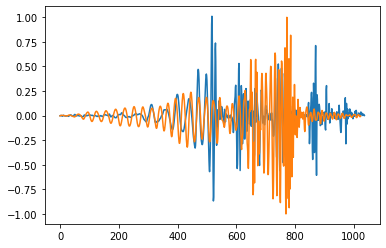

In [48]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[7578:8602][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [49]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7578:8602]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7578:8602]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [50]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190412_reconstruction_CI_dilated_CNN_timesteps_25_1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


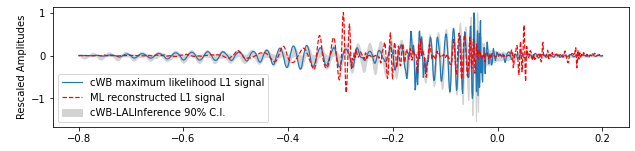

In [51]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW190814

In [52]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190814_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [53]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190814.hdf', 'r')
strain = f1['GW190814']['l1_strain'][()]

strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 1024)
strain = np.array(strain)


X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [54]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


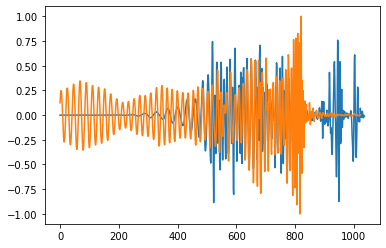

In [55]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[9433:10457][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [56]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[9433:10457]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[9433:10457]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [57]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/GW190814_reconstruction_CI_dilated_CNN_timesteps_25_1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


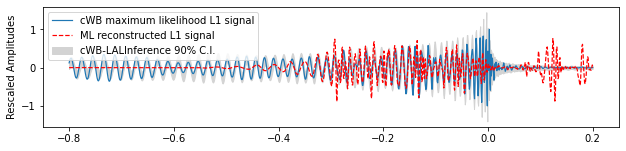

In [58]:
plot_reconstructed(decoded_signals[0][::2][0:1024], np.squeeze(cwb_reconst), new_upper, new_lower)
